In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from utils import *
from sklearn.preprocessing import StandardScaler
# from tests import *

# Algorithms
from byz_vr_marina import *
from byz_vr_marina_no_sync import *
from byz_dasha_page import *

%matplotlib inline

# Dataset Inspection

In [28]:
%%time
dataset = "w8a"
num_of_workers = 16
num_of_byz = 3
l2 = 0.1
setting = 'NC'

CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 23.8 µs


In [29]:
A, y, m, n, sparsity_A = prepare_data(dataset)

In [30]:
%%time

G = num_of_workers - num_of_byz
mul = int(m/G)
A = A[:mul*G]
y = y[:mul*G]

denseA = A.toarray()
clients_A, clients_y = distrib_data(A, y, num_of_workers, num_of_byz)
# clients_A = [A for i in range(num_of_workers)]
# clients_y = [y for i in range(num_of_workers)]
L, average_L, worst_L = compute_L(dataset, A, clients_A, num_of_byz, l2)

print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_i : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
print("Sparsity of A: ", sparsity_A)

Datasize:  49749 , dimension:  300
Smoothness constant of f         :  0.7610856341471876
Average smoothness const of f_i :  0.8622327472226651
Worst smoothness const of f_ij   :  28.6
Sparsity of A:  0.03883401341400497
CPU times: user 7.74 ms, sys: 60.3 ms, total: 68 ms
Wall time: 64.7 ms


# True Solution

In [31]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l1 = 0

In [32]:
%%time
param = [A, y, l2, setting, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-30)

print(res_solver.success)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89569D+01    |proj g|=  3.66562D-01

At iterate    1    f=  3.92473D+00    |proj g|=  4.63417D-02

At iterate    2    f=  1.97152D+00    |proj g|=  3.31317D-02

At iterate    3    f=  1.47529D+00    |proj g|=  3.32059D-02

At iterate    4    f=  1.12422D+00    |proj g|=  3.36654D-02

At iterate    5    f=  9.76789D-01    |proj g|=  3.26152D-02

At iterate    6    f=  8.70081D-01    |proj g|=  3.17484D-02

At iterate    7    f=  8.00119D-01    |proj g|=  3.43008D-02

At iterate    8    f=  7.15389D-01    |proj g|=  2.02136D-02

At iterate    9    f=  6.75963D-01    |proj g|=  2.85706D-02

At iterate   10    f=  6.25164D-01    |proj g|=  3.33135D-02

At iterate   11    f=  6.06590D-01    |proj g|=  3.88573D-02

At iterate   12    f=  5.64554D-01    |proj g|=  3.07093D-02

At iterate   13    f=  5.0

 This problem is unconstrained.



At iterate   37    f=  4.05527D-01    |proj g|=  1.45313D-09

At iterate   38    f=  4.05527D-01    |proj g|=  5.78300D-10

At iterate   39    f=  4.05527D-01    |proj g|=  8.97766D-11

At iterate   40    f=  4.05527D-01    |proj g|=  2.95457D-11
False
CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 366 ms

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  300     41     88      2     0     0   2.955D-11   4.055D-01
  F =  0.40552662528952699     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [33]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

In [34]:
shift_param = 1.0
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

In [35]:
print("f(x^0) = ", logreg_loss(x_init, [denseA, y, l2, setting]))
print("f(x^*) = ", logreg_loss(x_star, [denseA, y, l2, setting]))

f(x^0) =  17.15224633554051
f(x^*) =  0.405526625289527


# Algorithm Run

In [36]:
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)+'_'+setting+'_' 
attack = "IPM"
agg = "CM"
T = 2000
save_info_period = 30 
mul = int(m/G)

bits_cieling = 1e4

## MARINA hyperparameters

In [37]:
batch_size = int(0.01*mul)
sparsificator = randk
sparsificator_params = [int(0.1 * n), "rand-1"]
p = min((batch_size / mul), 1/n)

In [38]:
R_no_sync = max(n/sparsificator_params[0] -1, mul/batch_size)*((average_L**2 + worst_L**2/batch_size)*(n/sparsificator_params[0] -1) + worst_L**2/batch_size) * (np.sqrt(1/G) + np.sqrt(8*(256/15)*num_of_byz/num_of_workers))**2
gamma_th_m_no_sync = 1 / (L + R_no_sync ** 0.5)

In [39]:
gamma_th_m_no_sync

0.0012522386788028717

In [40]:
R_m = 12 * max(n/sparsificator_params[0] -1, mul/batch_size)*((average_L**2 + worst_L**2/batch_size)*(n/sparsificator_params[0] -1) + worst_L**2/batch_size) * (1/G + (8*(256/15)*num_of_byz/num_of_workers)/p)+ 24 * max(n/sparsificator_params[0] -1, mul/batch_size) * (4*(256/15)*num_of_byz/num_of_workers)/p
gamma_th_m = 1 / (L + R_m ** 0.5)

In [41]:
gamma_th_m

2.1985740970638915e-05

In [42]:
bits_per_round = p *n +(1-p)*sparsificator_params[0]
T_m = bits_cieling/bits_per_round

In [43]:
bits_cieling

10000.0

In [44]:
bits_per_round

30.900000000000002

In [45]:
p *n +(1-p)*sparsificator_params[0]

30.900000000000002

In [46]:
T_m

323.62459546925567

## DASHA hyperparameters

In [47]:
batch_size = int(0.01*mul)
sparsificator = randk
sparsificator_params = [int(0.1 * n), "rand-1"]
p_d = (batch_size / mul) 
mom = 1/(2*(n/sparsificator_params[0])-1)

In [48]:
omega = n/sparsificator_params[0]-1
R_dp =(12*omega*(2*omega+1)*(average_L**2 + worst_L**2/batch_size) + 2*(mul/batch_size)* worst_L**2/batch_size) * (np.sqrt(1/G) + np.sqrt(8*(256/15)*num_of_byz/num_of_workers))**2
gamma_th_dp = 1 / (L + R_dp ** 0.5)

In [49]:
T_dp = bits_cieling/sparsificator_params[0]

In [50]:
T_dp 

333.3333333333333

## Finetuning Stepsize

In [51]:
print(gamma_th_m, gamma_th_dp, gamma_th_m_no_sync)

2.1985740970638915e-05 0.0008371661246580443 0.0012522386788028717


In [316]:
gammas_m_ns = [(2**i) * gamma_th_m_no_sync for i in range(0,10,2)]
gammas_dp = [(2**i) * gamma_th_dp for i in range(0,10,2)]
gammas_m = [(2**(i)) * gamma_th_m for i in range(0,10,2)]

In [29]:
for gamma in gammas_m_ns:
    byz_vr_marina_no_sync(filename=filename, x_init=x_init, A=denseA, y=y, clients_A=clients_A, clients_y=clients_y, gamma=gamma, num_of_byz=num_of_byz, p=p, 
                    num_of_workers=num_of_workers, attack=attack, agg=agg, sparsificator=sparsificator, 
                    sparsificator_params=sparsificator_params, setting=setting, l2=l2,  T=T, max_t=np.inf, batch_size=batch_size, 
                    save_info_period=save_info_period, x_star=x_star, f_star=f_star)

Data distributed correctly
Data distributed correctly
Data distributed correctly
Data distributed correctly
Data distributed correctly


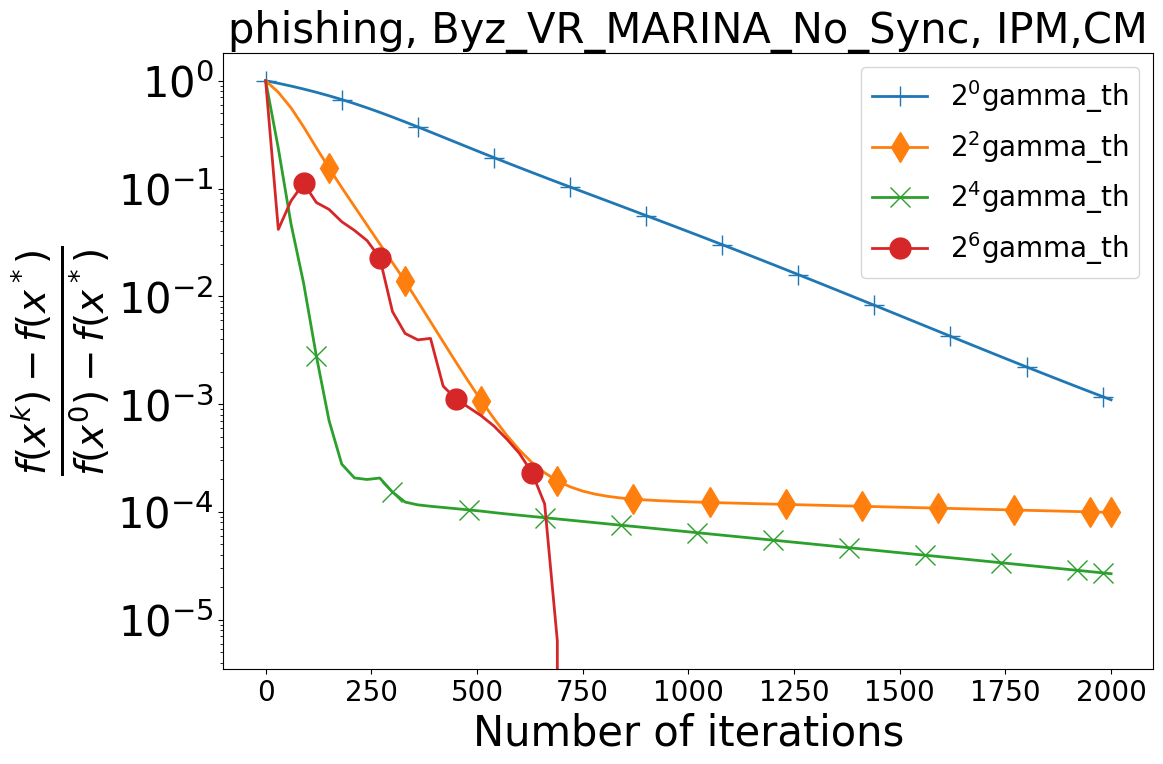

In [30]:
methods = [
    ['Byz_VR_MARINA_No_Sync', [gammas_m_ns[i], l2, p, T, num_of_workers, batch_size, num_of_byz, attack, agg], None, r"$2^{}$".format(2*i)+"gamma_th"] for i in range(len(gammas_m_ns)-1)
]
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+"Byz_VR_MARINA_No_Sync, " + attack + ',' + "CM"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_Byz_VR_MARINA_one_"+attack+"_"+agg+"_epochs_"+str(T)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, "finetuning", save_fig]
make_plots(args_for_plots)

In [31]:
for gamma in gammas_m:
    byz_vr_marina(filename=filename, x_init=x_init, A=denseA, y=y, clients_A=clients_A, clients_y=clients_y, gamma=gamma, num_of_byz=num_of_byz, p=p, 
                    num_of_workers=num_of_workers, attack=attack, agg=agg, sparsificator=sparsificator, 
                    sparsificator_params=sparsificator_params, setting=setting, l2=l2,  T=T, max_t=np.inf, batch_size=batch_size, 
                    save_info_period=save_info_period, x_star=x_star, f_star=f_star)

Data distributed correctly
Data distributed correctly
Data distributed correctly
Data distributed correctly
Data distributed correctly


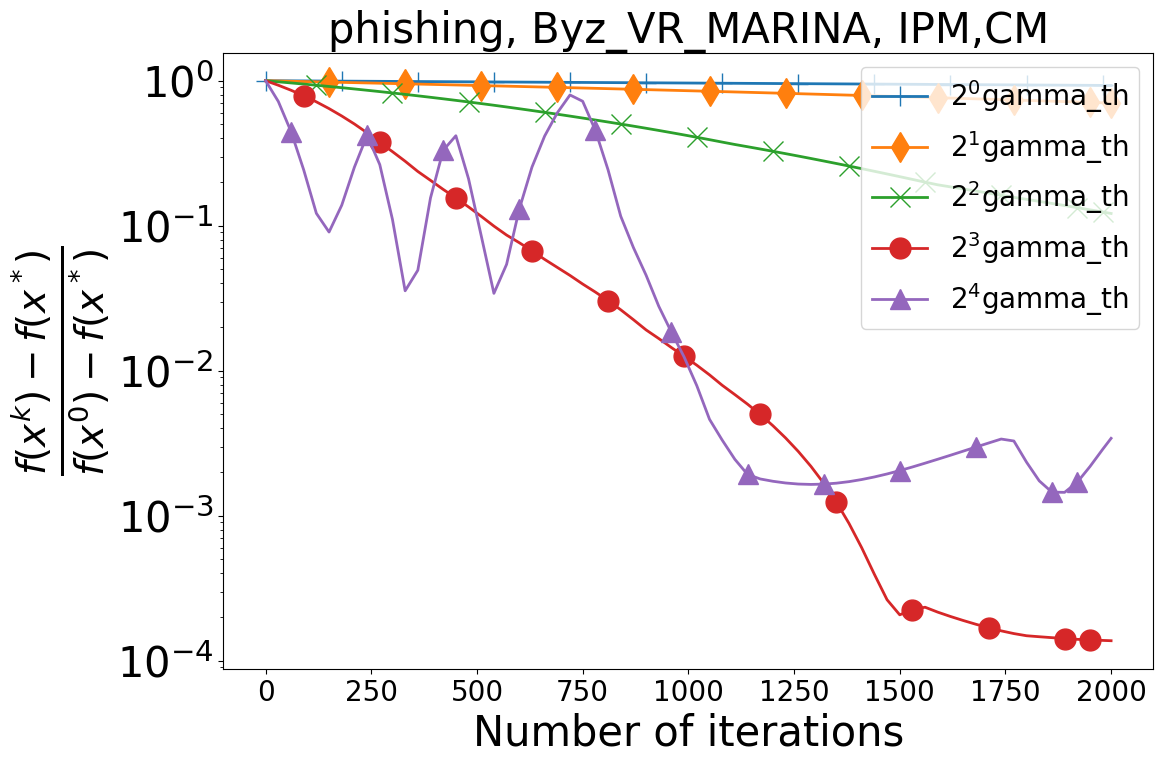

In [32]:
methods = [
    ['Byz_VR_MARINA', [gammas_m[i], l2, p, T, num_of_workers, batch_size, num_of_byz, attack, agg], None, r"$2^{}$".format(i)+"gamma_th"] for i in range(len(gammas_m))
]
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+"Byz_VR_MARINA, " + attack + ',' + "CM"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_Byz_VR_MARINA_one_"+attack+"_"+agg+"_epochs_"+str(T)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, "finetuning", save_fig]
make_plots(args_for_plots)

In [33]:
for gamma in gammas_dp:
    byz_dasha_page(filename=filename, x_init=x_init, A=denseA, y=y, clients_A=clients_A, clients_y=clients_y, gamma=gamma, num_of_byz=num_of_byz, p=p_d, mom=mom,
                    num_of_workers=num_of_workers, attack=attack, agg=agg, sparsificator=sparsificator, 
                    sparsificator_params=sparsificator_params, setting=setting, l2=l2,  T=T, max_t=np.inf, batch_size=batch_size, 
                    save_info_period=save_info_period, x_star=x_star, f_star=f_star)

Data distributed correctly
Data distributed correctly
Data distributed correctly
Data distributed correctly
Data distributed correctly


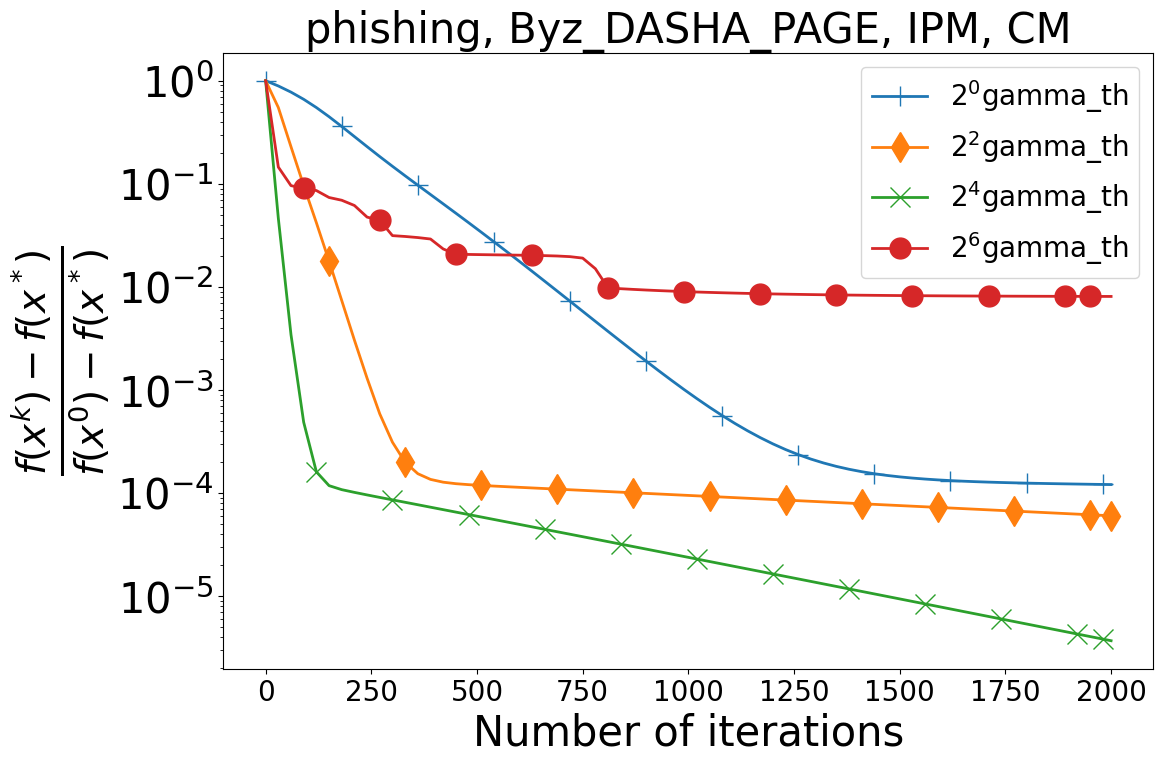

In [34]:
methods = [
    ['Byz_DASHA_PAGE', [gammas_dp[i], l2, p_d, T, num_of_workers, batch_size, num_of_byz, attack, agg], None, r"$2^{}$".format(2*i)+"gamma_th"] for i in range(len(gammas_dp)-1)
]
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+"Byz_DASHA_PAGE, " + attack + ', ' 'CM'
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_Byz_VR_MARINA_one_"+attack+"_"+agg+"_epochs_"+str(T)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, "finetuning", save_fig]
make_plots(args_for_plots)

## Runtime

In [317]:
gamma_m = gammas_m[4]
gamma_m_no_sync = gammas_m_ns[2]
gamma_dp = gammas_dp[2]

In [318]:
print(gamma_m, gamma_m_no_sync, gamma_dp)

0.0995918292876357 0.30422778081480895 0.6251648699372048


In [319]:
%%time
seed=123
np.random.seed(seed)
random.seed(seed)

res = byz_vr_marina(filename=filename, x_init=x_init, A=denseA, y=y, clients_A=clients_A, clients_y=clients_y, gamma=gamma_m, num_of_byz=num_of_byz, p=p, 
                    num_of_workers=num_of_workers, attack=attack, agg='GM', sparsificator=sparsificator, 
                    sparsificator_params=sparsificator_params, setting=setting, l2=l2,  T=T, max_t=np.inf, batch_size=batch_size, 
                    save_info_period=save_info_period, x_star=x_star, f_star=f_star)

Data distributed correctly
CPU times: user 51.5 s, sys: 3min 34s, total: 4min 26s
Wall time: 10.9 s


In [320]:
%%time
seed=123
np.random.seed(seed)
random.seed(seed)

res_1 = byz_vr_marina_no_sync(filename=filename, x_init=x_init, A=denseA, y=y, clients_A=clients_A, clients_y=clients_y, gamma=gamma_m_no_sync, num_of_byz=num_of_byz, p=p, 
                    num_of_workers=num_of_workers, attack=attack, agg=agg, sparsificator=sparsificator, 
                    sparsificator_params=sparsificator_params, setting=setting, l2=l2,  T=T, max_t=np.inf, batch_size=batch_size, 
                    save_info_period=save_info_period, x_star=x_star, f_star=f_star)

Data distributed correctly
CPU times: user 51.7 s, sys: 3min 35s, total: 4min 27s
Wall time: 10.8 s


In [321]:
%%time
seed=123
np.random.seed(seed)
random.seed(seed)

res_2 = byz_dasha_page(filename=filename, x_init=x_init, A=denseA, y=y, clients_A=clients_A, clients_y=clients_y, gamma=gamma_dp, num_of_byz=num_of_byz, p=p_d, mom=mom,
                    num_of_workers=num_of_workers, attack=attack, agg=agg, sparsificator=sparsificator, 
                    sparsificator_params=sparsificator_params, setting=setting, l2=l2,  T=T, max_t=np.inf, batch_size=batch_size, 
                    save_info_period=save_info_period, x_star=x_star, f_star=f_star)

Data distributed correctly
CPU times: user 51.2 s, sys: 3min 36s, total: 4min 27s
Wall time: 11 s


# Visualisation

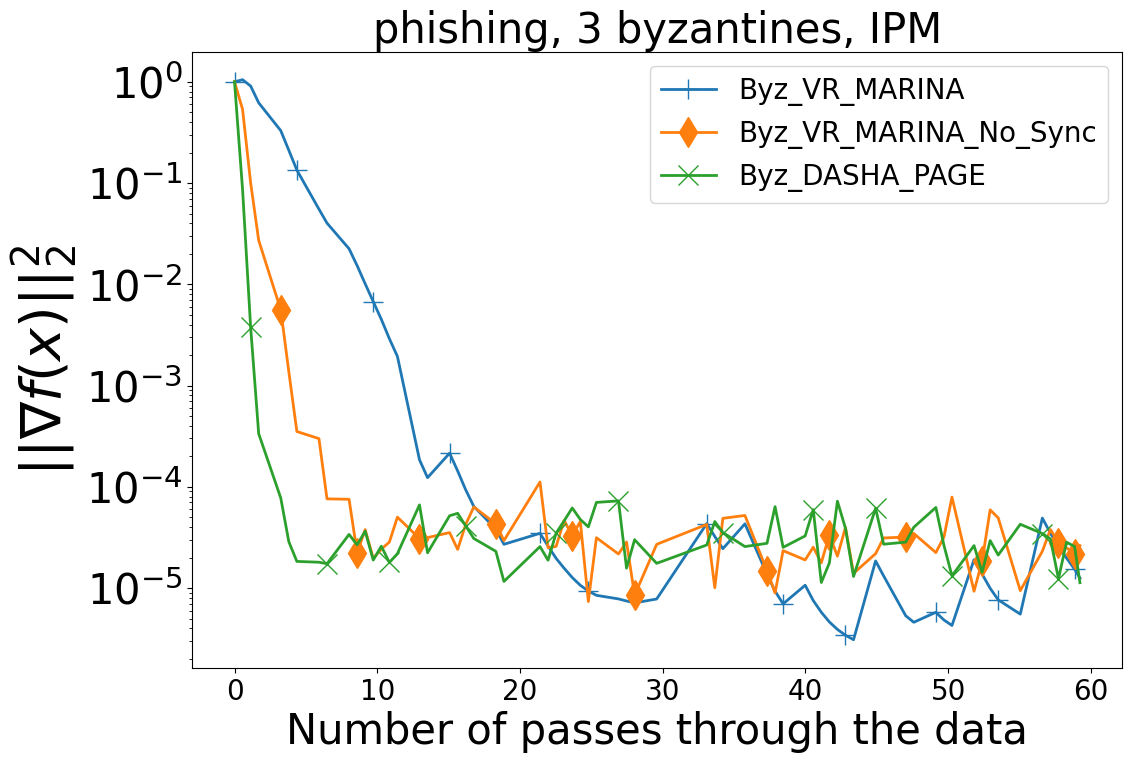

In [322]:
methods = [
    ['Byz_VR_MARINA', [gamma_m, l2, p, T, num_of_workers, batch_size, num_of_byz, attack, 'GM'], None],
    ['Byz_VR_MARINA_No_Sync', [gamma_m_no_sync, l2, p, T, num_of_workers, batch_size, num_of_byz, attack, agg], None],
    ['Byz_DASHA_PAGE', [gamma_dp, l2, p_d, T, num_of_workers, batch_size, num_of_byz, attack, agg], None]
]
mode_y = 'norm_grad'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+ str(num_of_byz)+ " byzantines"+", "+attack
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_Byz_VR_MARINA_one_"+attack+"_"+agg+"_epochs_"+str(T)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, "comparison", save_fig]
make_plots(args_for_plots)